In [43]:
import pandas as pd

In [44]:
import re

In [45]:
from nltk.stem.porter import *

In [46]:
from nltk.corpus import stopwords

# NLTK provides a list of wtopwords; read it and keep it handy

In [47]:
stopwords_list = stopwords.words( 'english')

In [113]:
'a' in stopwords_list

True

# PorterStemmer Algo will be used to stem the words i.e reduce inflection . eg. walk and walked will have stem as 'walk'

In [49]:
stemmer = PorterStemmer()

# This transform function is used to preprocess the data at the time of reading the file itself. This is much more effieicnt than doing the preprocessing after reading the entire file

In [123]:
def transform( val ):
    val = re.sub( "^b[\"\']|[\"\']", "", str( val ).lower() )
    val_new = ""
    for word in re.split( "[\t\s]+", val ):
        stemmed_word = stemmer.stem( word )
        if stemmed_word in stopwords_list: continue
        val_new = val_new + " " + stemmed_word
    return val_new

# Create a map of column id and converter function which will get applied to that col

In [124]:
c = {}
for i in range( 2, 27 ):
    c[i] = lambda x : transform( x )

In [125]:
df = pd.read_csv( "/home/brij/smu/MachineLearning/project/NewsToMarket/data/Combined_News_DJIA.csv", sep=",", converters=c )

In [126]:
df.iloc[0]['Top1']

' georgia two russian warplan countri move brink war'

# Create another field with combined news for each day

In [127]:
df['combined_news'] = df.apply( lambda row: " ".join( map( lambda x: str(x), row[2:] ) ), axis=1 )

In [128]:
df.to_csv( "/home/brij/smu/MachineLearning/project/NewsToMarket/data/cleaned_combined_News_DJIA.csv", 
            sep=",", doublequote=True, index=False )

In [129]:
df2 = pd.read_csv( "/home/brij/smu/MachineLearning/project/NewsToMarket/data/cleaned_combined_News_DJIA.csv", sep="," )

In [130]:
df2['combined_news'][:10]

0     georgia two russian warplan countri move brin...
1     whi wont america nato help us? wont help us n...
2     rememb ador 9-year-old sang open ceremonies? ...
3      u.s. refus israel weapon attack iran: report...
4     expert admit legalis drug   war south osetia ...
5     mom miss gay man: bad 21-year-old cheerleader...
6     afghan prison, major femal prison serv 20-yea...
7     man arrest lock five hour take photo polic va...
8     two elderli chines women sentenc year re-educ...
9     british resid held guantanamo bay win legal b...
Name: combined_news, dtype: object

# "#########Exploratory Analysis######### "

In [155]:
df2['word_count'] = df2['combined_news'].apply( lambda x: len( re.split( "[\t\s]+", x.strip( "\n" ) )))

In [156]:

df2['word_count'].shape

(1989,)

In [160]:
import seaborn as sns

In [164]:
import matplotlib.pyplot as plt

In [259]:
plt.subplot( 1,2,1)

In [260]:
sns.distplot( df2[(df2.Label==1)]['word_count'], bins=20, hist=True, kde=True, rug=True, norm_hist=True, label="Label=1"   ) 

/home/brij/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [261]:
plt.xticks( rotation='vertical')

(array([ 100.,  150.,  200.,  250.,  300.,  350.,  400.,  450.,  500.,  550.]),
 <a list of 10 Text xticklabel objects>)

In [262]:
plt.legend()

In [263]:
plt.subplot(1, 2, 2)

In [264]:
sns.distplot( df2[(df2.Label==0)]['word_count'], bins=20, hist=True, kde=True, rug=True, norm_hist=True, label="Label=0"   ) 

/home/brij/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [265]:
plt.legend()

In [266]:
plt.xticks( rotation='vertical')

(array([ 100.,  150.,  200.,  250.,  300.,  350.,  400.,  450.,  500.]),
 <a list of 9 Text xticklabel objects>)

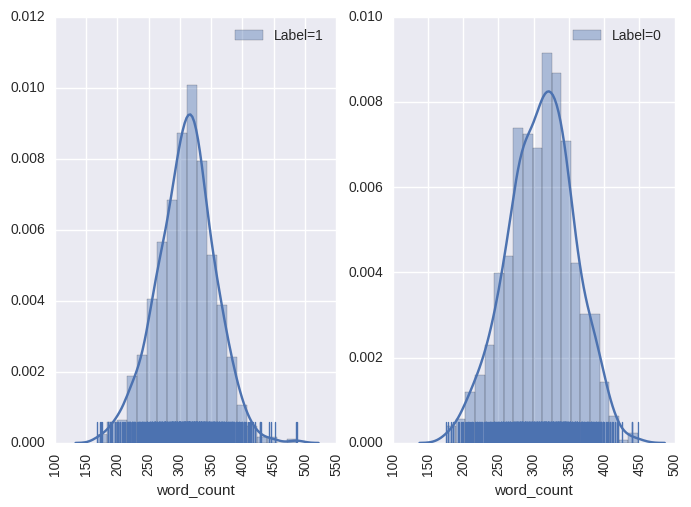

In [267]:
plt.show()

## Mean word count is centered around 300. Label = 0 seems slightly right skewed

In [257]:

sns.boxplot( x='Label', y='word_count', data=df2)

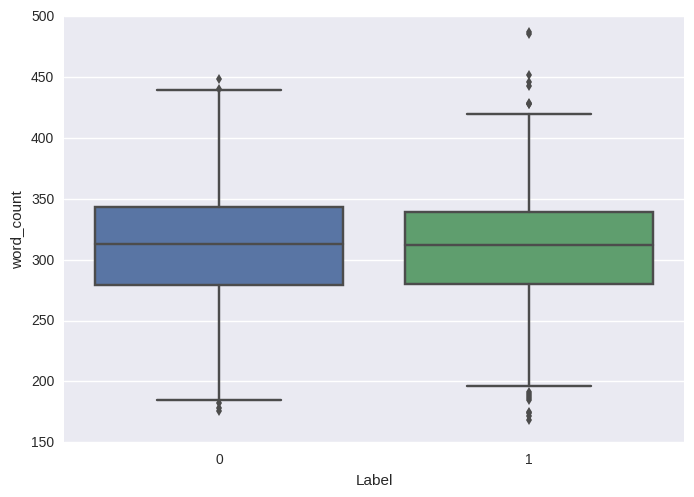

In [258]:
plt.show()

## More variation of teh word counts can be seen for label = 1

# Lets check the distribution of shared words each day

In [311]:
df2['shared_word_count'] = df2['combined_news'].apply( lambda x : np.count_nonzero( pd.Series( re.split( "[\t\s]+", x ) )
                                                            .value_counts().values != 1 ))

In [315]:
plt.subplot( 1, 2, 1)
sns.distplot( df2[(df2.Label==0)]['shared_word_count'], bins=20, kde=True, hist=True, norm_hist=True, label="Label=0" )
plt.xticks( rotation='vertical' )
plt.legend()

/home/brij/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [316]:
plt.subplot( 1, 2, 2)
sns.distplot( df2[(df2.Label==1)]['shared_word_count'], bins=20, kde=True, hist=True, norm_hist=True, label="Label=1" )
plt.xticks( rotation='vertical' )
plt.legend()

/home/brij/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


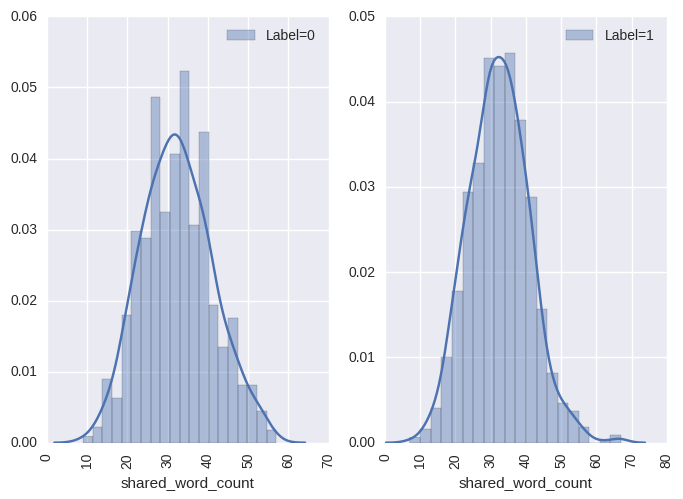

In [317]:
plt.show()

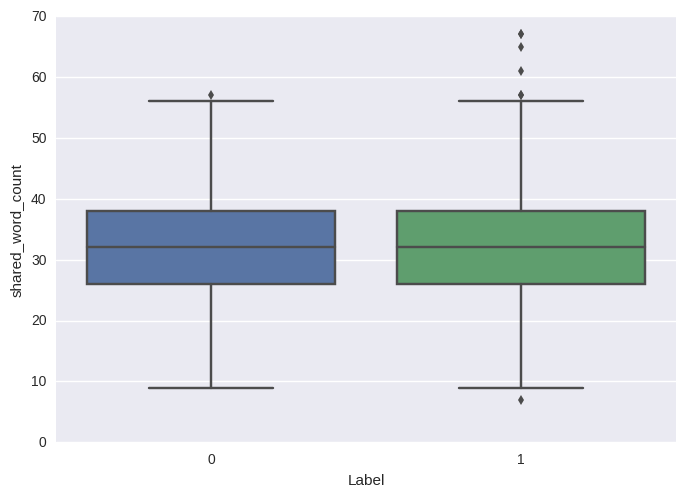

In [318]:

sns.boxplot( x='Label', y='shared_word_count', data=df2)
plt.show()

## Not much difference is seen in the shared word count between the classes